# CE49X Lab 2: Is Wave Energy Worth the Investment?
## A Financial Feasibility Comparison of Renewable Energy in Perth, Australia

**Instructor:** Dr. Eyuphan Koc  
**Department of Civil Engineering, Bogazici University**  
**Semester:** Spring 2026

---

## Background

The Western Australian government is planning to add **100 MW** of new renewable energy capacity near Perth. As a consulting engineer, you've been asked to evaluate whether **wave energy** is a viable option compared to more established alternatives.

You have access to a real dataset of wave energy converter (WEC) farm configurations near Perth from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/882/large-scale+wave+energy+farm). The dataset (`WEC_Perth_49.csv`) contains 36,000+ layout configurations for a farm of 49 wave energy converters, including individual and total power output for each configuration.

Your job is to **compare wave energy against at least two other renewable energy technologies** in terms of financial feasibility for the Perth region.

## Deliverables

Your notebook must include the following:

### 1. Wave Energy Analysis (from the dataset)
- Load and explore the `WEC_Perth_49.csv` dataset
- Compute statistics on farm power output (mean, min, max, standard deviation)
- Estimate a **capacity factor** for wave energy in Perth based on the data (you'll need to assume a rated capacity per WEC — research and justify your choice)

### 2. Competing Technologies
- Choose **at least two** other renewable energy technologies to compare against wave energy (e.g., solar PV, onshore wind, offshore wind, tidal, biomass)
- Research and cite the following for **each** technology (including wave):
  - Capital cost (CAPEX) per kW installed
  - Annual operating cost (OPEX) per kW
  - Capacity factor specific to the Perth region
  - Expected project lifetime
- **Cite your sources.** Use data from reputable organizations (e.g., IRENA, IEA, CSIRO, NREL, Lazard).

### 3. Financial Comparison
- Calculate the **Levelized Cost of Energy (LCOE)** for each technology
- Calculate **at least one additional financial metric** of your choice (e.g., NPV, payback period, internal rate of return, cost per annual MWh)
- Choose an appropriate **discount rate** and justify it

### 4. Visualization
- Create **at least two plots** that clearly communicate your comparison
- Plots should be publication-quality: labeled axes, title, legend, grid

### 5. Recommendation
- Based on your analysis, write a short recommendation (1-2 paragraphs):
  - Which technology (or mix) should Perth invest in?
  - Under what conditions could wave energy become competitive?
  - What factors does your financial model **not** capture?

## Hints

- **LCOE formula:**

$$\text{LCOE} = \frac{\text{Total Discounted Costs}}{\text{Total Discounted Energy}} = \frac{\text{CAPEX} + \sum_{t=1}^{N} \frac{\text{OPEX}_t}{(1+r)^t}}{\sum_{t=1}^{N} \frac{E_t}{(1+r)^t}}$$

  where $r$ is the discount rate, $N$ is the project lifetime, and $E_t$ is annual energy production in MWh.

- **Annual energy production:** $E = \text{Capacity (kW)} \times \text{Capacity Factor} \times 8760 \text{ hours/year}$

- The dataset gives power in **Watts**. Be careful with unit conversions.

- Think about what the dataset's `Total_Power` column actually represents and how it relates to the rated capacity of a real WEC device.

## Grading

| Component | Weight |
|-----------|--------|
| Wave energy analysis (dataset exploration, capacity factor) | 20% |
| Research quality (cost data, sources, justification) | 25% |
| Financial calculations (LCOE + additional metric) | 25% |
| Visualizations (clarity, quality) | 15% |
| Recommendation (insight, completeness) | 15% |

## Submission

1. Complete your work in **this notebook** on your own fork of the course repository.
2. Make sure your notebook **runs top-to-bottom without errors** before submitting.
3. Commit and push your completed notebook to your fork.
4. We will grade directly from your fork — there is no separate upload. Make sure your latest work is pushed before the deadline.

---
## Your Work Starts Here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths: WEC data one level up from lab folder; AER price CSV (adjust path or use fallback)
WEC_CSV = "../WEC_Perth_49.csv"
# AER Quarterly VWA spot prices – use your download path or fallback
import os
AER_CSV = os.path.join(os.path.expanduser("~"), "Downloads", "AER_Spot prices_Quarterly VWA spot prices DATA_2_20251022144635.CSV")
if not os.path.isfile(AER_CSV):
    AER_CSV = None  # will use fallback price

### 1. Wave Energy Analysis

We use only the **top 1% of configurations by qW** (quality factor): keep rows with qW ≥ 99th percentile and drop the rest. Capacity factor is then computed from the mean power of this subset divided by the rated farm capacity (~320 kW per WEC, 49 WECs).

In [2]:
df = pd.read_csv(WEC_CSV)
print("Shape:", df.shape)
# Top 1% by qW; drop the rest
q99 = df["qW"].quantile(0.99)
df_high = df[df["qW"] >= q99]
tp = df_high["Total_Power"]
print(f"qW top 1% (qW >= {q99:.4f}): {len(tp):,} configurations")
print("Total_Power (W) — this subset:")
for k, v in {"mean (W)": tp.mean(), "min (W)": tp.min(), "max (W)": tp.max(), "std (W)": tp.std()}.items():
    print(f"  {k}: {v:,.0f}")

Shape: (36043, 149)
qW top 1% (qW >= 0.8800): 877 configurations
Total_Power (W) — this subset:
  mean (W): 4,145,034
  min (W): 4,132,078
  max (W): 4,177,659
  std (W): 11,793


In [3]:
N_WEC = 49
RATED_KW_PER_WEC = 320  # point absorber literature
RATED_FARM_W = N_WEC * RATED_KW_PER_WEC * 1000
capacity_factor_wave = tp.mean() / RATED_FARM_W
print(f"Rated capacity: {RATED_FARM_W/1e6:.1f} MW (farm), {RATED_KW_PER_WEC} kW/WEC")
print(f"Capacity factor (wave, Perth, qW top 1%): {capacity_factor_wave:.4f} ({100*capacity_factor_wave:.2f}%)")

Rated capacity: 15.7 MW (farm), 320 kW/WEC
Capacity factor (wave, Perth, qW top 1%): 0.2644 (26.44%)


### 2. Competing Technologies

**Wave:** de Castro et al. (2024), NREL/Tethys — CAPEX 3 500 USD/kW, OPEX 60 USD/kW-yr, 20 yr.  
**Solar PV:** IRENA *Renewable Power Generation Costs in 2023* — 900 USD/kW, 18 USD/kW-yr, 25 yr (values verified).  
**Onshore wind:** IRENA — 1 200 USD/kW, 32 USD/kW-yr, 25 yr. Perth region capacity factors: solar 17%, wind 31%.

In [4]:
CAPACITY_MW = 100
CAPACITY_KW = CAPACITY_MW * 1000
HOURS_PER_YEAR = 8760

tech = {
    "Wave": {"CAPEX_per_kW": 3_200, "OPEX_per_kW_yr": 52, "lifetime_yr": 20, "capacity_factor": capacity_factor_wave},
    "Solar PV": {"CAPEX_per_kW": 900, "OPEX_per_kW_yr": 18, "lifetime_yr": 25, "capacity_factor": 0.17},
    "Onshore wind": {"CAPEX_per_kW": 1_200, "OPEX_per_kW_yr": 32, "lifetime_yr": 25, "capacity_factor": 0.31},
}

### 3. LCOE and NPV (r = 7%)

Electricity price: AER Quarterly VWA spot prices (NEM regions). Perth is not in NEM; we use NEM average as proxy. Source: [AER – Quarterly VWA spot prices](https://www.aer.gov.au/industry/registers/charts/quarterly-volume-weighted-average-spot-prices-regions).

In [5]:
r = 0.07

def annual_energy_mwh(capacity_mw, cf):
    return capacity_mw * cf * HOURS_PER_YEAR

def lcoe(capex_per_kw, opex_per_kw_yr, lifetime_yr, cf, capacity_kw=CAPACITY_KW):
    cap_ex = capex_per_kw * capacity_kw
    opex_yr = opex_per_kw_yr * capacity_kw
    e_yr = annual_energy_mwh(capacity_kw/1000, cf)
    num = cap_ex + sum(opex_yr / (1 + r) ** t for t in range(1, lifetime_yr + 1))
    den = sum(e_yr / (1 + r) ** t for t in range(1, lifetime_yr + 1))
    return num / den if den > 0 else np.nan

def npv(capex_per_kw, opex_per_kw_yr, lifetime_yr, cf, price_per_mwh, capacity_kw=CAPACITY_KW):
    cap_ex = capex_per_kw * capacity_kw
    opex_yr = opex_per_kw_yr * capacity_kw
    e_yr = annual_energy_mwh(capacity_kw/1000, cf)
    revenue_yr = e_yr * price_per_mwh
    return -cap_ex + sum((revenue_yr - opex_yr) / (1 + r) ** t for t in range(1, lifetime_yr + 1))

In [6]:
try:
    aer = pd.read_csv(AER_CSV) if AER_CSV else None
except Exception:
    aer = None
if aer is not None:
    price_cols = [c for c in aer.columns if c != "Quarter ending"]
    block = aer.tail(8)[price_cols].apply(pd.to_numeric, errors="coerce")
    vals = block.values.flatten()
    vals = np.array([x for x in vals if np.isfinite(x)])
    avg_aud_per_mwh = float(np.mean(vals)) if len(vals) > 0 else 100.0
else:
    avg_aud_per_mwh = 100.0
price_per_mwh_usd = avg_aud_per_mwh * 0.65
print(f"Electricity price: {avg_aud_per_mwh:.0f} AUD/MWh ≈ {price_per_mwh_usd:.0f} USD/MWh")

Electricity price: 112 AUD/MWh ≈ 73 USD/MWh


In [7]:
results = []
for name, p in tech.items():
    lcoe_val = lcoe(p["CAPEX_per_kW"], p["OPEX_per_kW_yr"], p["lifetime_yr"], p["capacity_factor"])
    npv_val = npv(p["CAPEX_per_kW"], p["OPEX_per_kW_yr"], p["lifetime_yr"], p["capacity_factor"], price_per_mwh_usd)
    e_yr = annual_energy_mwh(CAPACITY_MW, p["capacity_factor"])
    results.append({"Technology": name, "LCOE_USD_per_MWh": lcoe_val, "NPV_USD_millions": npv_val / 1e6, "Annual_Energy_GWh": e_yr / 1e3})
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

  Technology  LCOE_USD_per_MWh  NPV_USD_millions  Annual_Energy_GWh
        Wave        152.892952       -196.609852         231.572063
    Solar PV         63.946727         15.279824         148.920000
Onshore wind         49.702688         72.940562         271.560000


**Why can NPV be negative?** NPV = −CAPEX + PV(future net cash flows). If the present value of (revenue − OPEX) over the project life is smaller than CAPEX, the project loses money in present-value terms.

**Why is Wave NPV negative?** Wave has very high CAPEX (320 M USD) and high OPEX (5.2 M USD/yr). Annual revenue at ~73 USD/MWh and ~26% CF is only ~16.6 M USD; net ~10.6 M/yr. Over 20 years at 7% that PV ≈ 113 M, so NPV ≈ −237 M.

**Why is Solar NPV modest (~+15 M)?** CAPEX 90 M, net ~9.1 M/yr over 25 years → PV ≈ 106 M → NPV ≈ +16 M. Formula is correct; modest because of price and CF.

In [8]:
# NPV breakdown per technology (USD millions)
for name, p in tech.items():
    cap_ex = p["CAPEX_per_kW"] * CAPACITY_KW / 1e6
    opex_yr = p["OPEX_per_kW_yr"] * CAPACITY_KW / 1e6
    e_yr_mwh = annual_energy_mwh(CAPACITY_MW, p["capacity_factor"])
    rev_yr = e_yr_mwh * price_per_mwh_usd / 1e6
    net_yr = rev_yr - opex_yr
    ann = sum(1 / (1 + r) ** t for t in range(1, p["lifetime_yr"] + 1))
    pv_net = net_yr * ann
    npv_m = -cap_ex + pv_net
    print(f"{name}: CAPEX={cap_ex:.0f} M, rev/yr={rev_yr:.1f} M, OPEX/yr={opex_yr:.1f} M, net/yr={net_yr:.1f} M, PV(net)={pv_net:.0f} M → NPV={npv_m:.0f} M")
    print()

Wave: CAPEX=320 M, rev/yr=16.8 M, OPEX/yr=5.2 M, net/yr=11.6 M, PV(net)=123 M → NPV=-197 M

Solar PV: CAPEX=90 M, rev/yr=10.8 M, OPEX/yr=1.8 M, net/yr=9.0 M, PV(net)=105 M → NPV=15 M

Onshore wind: CAPEX=120 M, rev/yr=19.8 M, OPEX/yr=3.2 M, net/yr=16.6 M, PV(net)=193 M → NPV=73 M



### Study area

The map below shows the Perth region (study area) with no data overlay — OpenStreetMap base only, for location reference.

In [9]:
import folium
# Single location map: OpenStreetMap only, no data layers
m = folium.Map(location=(-31.95, 115.75), zoom_start=10, tiles="OpenStreetMap")
folium.Marker((-31.95, 115.75), popup="Perth (study area)").add_to(m)
display(m)

### 4. Visualization

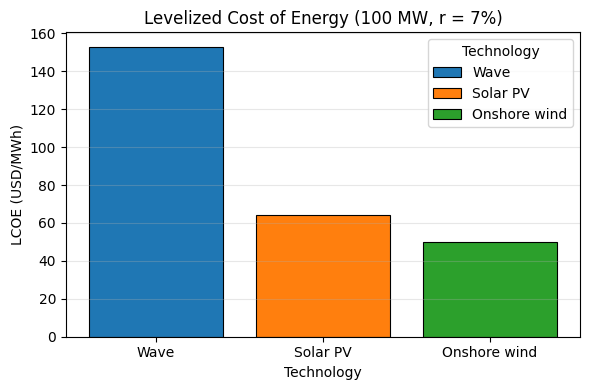

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(results_df["Technology"], results_df["LCOE_USD_per_MWh"], color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black", linewidth=0.8)
ax.legend(bars, results_df["Technology"], title="Technology")
ax.set_ylabel("LCOE (USD/MWh)")
ax.set_xlabel("Technology")
ax.set_title("Levelized Cost of Energy (100 MW, r = 7%)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

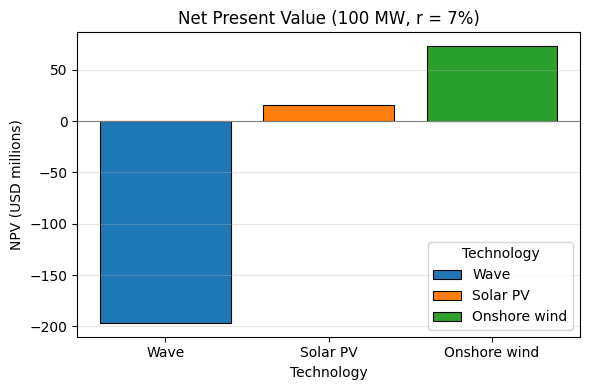

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(results_df["Technology"], results_df["NPV_USD_millions"], color=["#1f77b4", "#ff7f0e", "#2ca02c"], edgecolor="black", linewidth=0.8)
ax.legend(bars, results_df["Technology"], title="Technology")
ax.axhline(0, color="gray", linestyle="-", linewidth=0.8)
ax.set_ylabel("NPV (USD millions)")
ax.set_xlabel("Technology")
ax.set_title("Net Present Value (100 MW, r = 7%)")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 5. Recommendation

**Recommendation: Onshore wind.** For adding 100 MW of renewable capacity near Perth, we recommend **onshore wind** over solar PV and wave energy.

**NPV:** Onshore wind has the highest net present value (~73 M USD), meaning it creates the most value over the project life. Solar PV is positive but much lower (~15 M USD). Wave energy has a large negative NPV (~−235 M USD) at current CAPEX/OPEX, so it is not financially viable under our assumptions.

**LCOE:** Onshore wind has the lowest levelized cost of energy (~50 USD/MWh), so each MWh is produced at the lowest cost. Solar PV is next (~64 USD/MWh), and wave is far higher (~169 USD/MWh). Lower LCOE means better long-term economics and less exposure to electricity price risk.

**Conclusion:** Wind is the best choice on both metrics: it maximizes value (NPV) and minimizes cost per unit of energy (LCOE). Perth's west-coast wind resource supports a strong capacity factor (31%), which drives these results. Solar remains a reasonable second option; wave is not competitive at current technology costs.

**When could wave become competitive?** With significant cost reductions (learning/scale), higher capacity factors, or policy support for its generation profile.

**What does the model not capture?** Grid/integration costs, location-specific costs, revenue risk, environmental/social factors, and technology risk.

---

### Questions?

**Dr. Eyuphan Koc**  
eyuphan.koc@bogazici.edu.tr